In [1]:
import math as m
import numpy as np
np.random.seed(1234)
import scipy.io
import time
import tensorflow as tf
from scipy.interpolate import griddata
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import re
from numpy import genfromtxt
from functools import reduce

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Topology-preserving methods for electrode positions 

In [3]:
def cart2sph(x, y, z):
    """
    Transform Cartesian coordinates to spherical
    :param x: X coordinate
    :param y: Y coordinate
    :param z: Z coordinate
    :return: radius, elevation, azimuth
    """
    x2_y2 = x**2 + y**2
    r = m.sqrt(x2_y2 + z**2)                    # r
    elev = m.atan2(z, m.sqrt(x2_y2))            # Elevation
    az = m.atan2(y, x)                          # Azimuth
    return r, elev, az


def pol2cart(theta, rho):
    """
    Transform polar coordinates to Cartesian
    :param theta: angle value
    :param rho: radius value
    :return: X, Y
    """
    return rho * m.cos(theta), rho * m.sin(theta)

def azim_proj(pos):
    """
    Computes the Azimuthal Equidistant Projection of input point in 3D Cartesian Coordinates.
    Imagine a plane being placed against (tangent to) a globe. If
    a light source inside the globe projects the graticule onto
    the plane the result would be a planar, or azimuthal, map
    projection.
    :param pos: position in 3D Cartesian coordinates
    :return: projected coordinates using Azimuthal Equidistant Projection
    """
    [r, elev, az] = cart2sph(pos[0], pos[1], pos[2])
    return pol2cart(az, m.pi / 2 - elev)

#Methods for generation of images from EEG time-series

##Interesting data processing techniques to decompose EEG signals into temporal frames and to extract frequency components. 

#### These methods are not used in this final version as better quality datasets were find during the project, and were already pre-processed.

In [4]:
def get_fft(snippet):
    Fs = 128.0;  # sampling rate
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector
    y = snippet

    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] 

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)] 
    return frq,abs(Y)

In [5]:
def theta_alpha_beta_averages(f,Y):
    theta_range = (4,8)
    alpha_range = (8,12)
    beta_range = (12,40)
    theta = Y[(f>theta_range[0]) & (f<=theta_range[1])].mean()
    alpha = Y[(f>alpha_range[0]) & (f<=alpha_range[1])].mean()
    beta = Y[(f>beta_range[0]) & (f<=beta_range[1])].mean()
    return theta, alpha, beta

In [6]:
def make_steps(samples,frame_duration,overlap):
    '''
    in:
    samples - number of samples in the session
    frame_duration - frame duration in seconds 
    overlap - float fraction of frame to overlap in range (0,1)
    
    out: list of tuple ranges
    '''
    Fs = 128 
    i = 0
    intervals = []
    samples_per_frame = Fs * frame_duration
    while i+samples_per_frame <= samples:
        intervals.append((i,i+samples_per_frame))
        i = i + samples_per_frame - int(samples_per_frame*overlap)
    return intervals

In [7]:
def make_frames(df,frame_duration):
    '''
    in: dataframe or array with all channels, frame duration in seconds
    out: array of theta, alpha, beta averages for each probe for each time step
        shape: (n-frames,m-probes,k-brainwave bands)
    '''
    Fs = 128.0
    frame_length = Fs*frame_duration
    frames = []
    steps = make_steps(len(df),frame_duration,overlap)
    for i,_ in enumerate(steps):
        frame = []
        if i == 0:
            continue
        else:
            for channel in df.columns:
                snippet = np.array(df.loc[steps[i][0]:steps[i][1],int(channel)])
                f,Y =  get_fft(snippet)
                theta, alpha, beta = theta_alpha_beta_averages(f,Y)
                frame.append([theta, alpha, beta])
            
        frames.append(frame)
    return np.array(frames)

In [8]:
def make_data_pipeline(file_names,labels,image_size,frame_duration,overlap):
    '''
    IN: 
    file_names - list of strings for each input file (one for each subject)
    labels - list of labels for each
    image_size - int size of output images in form (x, x)
    frame_duration - time length of each frame (seconds)
    overlap - float fraction of frame to overlap in range (0,1)
    
    OUT:
    X: np array of frames (unshuffled)
    y: np array of label for each frame (1 or 0)
    '''    
    Fs = 128.0   #sampling rate
    frame_length = Fs * frame_duration
    
    print('Generating training data...')
    
    
    for i, file in enumerate(file_names):
        print ('Processing session: ',file, '. (',i+1,' of ',len(file_names),')')
        data = genfromtxt(file, delimiter=',').T
        df = pd.DataFrame(data)
        print("df.shape ", df.shape)
        print("df ", df)
        X_0 = make_frames(df,frame_duration)
        X_1 = X_0.reshape(len(X_0),14*3)
        
        images = gen_images(np.array(locs_2d),X_1, image_size, normalize=False)
        images = np.swapaxes(images, 1, 3) 
        print(len(images), ' frames generated with label ', labels[i], '.')
        print('\n')
        if i == 0:
            X = images
            y = np.ones(len(images))*labels[0]
        else:
            X = np.concatenate((X,images),axis = 0)
            y = np.concatenate((y,np.ones(len(images))*labels[i]),axis = 0)
        
        
    return X,np.array(y)

## Generation of 2D-images from spectral, spacial and temporal EEG-measurements 

In [9]:
def augment_EEG(data, stdMult, pca=False, n_components=2):
    """
    Augment data by adding normal noise to each feature.
    :param data: EEG feature data as a matrix (n_samples x n_features)
    :param stdMult: Multiplier for std of added noise
    :param pca: if True will perform PCA on data and add noise proportional to PCA components.
    :param n_components: Number of components to consider when using PCA.
    :return: Augmented data as a matrix (n_samples x n_features)
    """
    augData = np.zeros(data.shape)
    if pca:
        pca = PCA(n_components=n_components)
        pca.fit(data)
        components = pca.components_
        variances = pca.explained_variance_ratio_
        coeffs = np.random.normal(scale=stdMult, size=pca.n_components) * variances
        for s, sample in enumerate(data):
            augData[s, :] = sample + (components * coeffs.reshape((n_components, -1))).sum(axis=0)
    else:
        # Add Gaussian noise with std determined by weighted std of each feature
        for f, feat in enumerate(data.transpose()):
            augData[:, f] = feat + np.random.normal(scale=stdMult*np.std(feat), size=feat.size)
    return augData


def augment_EEG_image(image, std_mult, pca=False, n_components=2):
    """
    Augment data by adding normal noise to each feature.
    :param image: EEG feature data as a a colored image [n_samples, n_colors, W, H]
    :param std_mult: Multiplier for std of added noise
    :param pca: if True will perform PCA on data and add noise proportional to PCA components.
    :param n_components: Number of components to consider when using PCA.
    :return: Augmented data as a matrix (n_samples x n_features)
    """
    augData = np.zeros((data.shape[0], data.shape[1], data.shape[2] * data.shape[3]))
    for c in range(image.shape[1]):
        reshData = np.reshape(data['featMat'][:, c, :, :], (data['featMat'].shape[0], -1))
        if pca:
            augData[:, c, :] = augment_EEG(reshData, std_mult, pca=True, n_components=n_components)
        else:
            augData[:, c, :] = augment_EEG(reshData, std_mult, pca=False)
    return np.reshape(augData, data['featMat'].shape)


In [10]:
def gen_images(locs, features, n_gridpoints, normalize=True,
               augment=False, pca=False, std_mult=0.1, n_components=2, edgeless=False):

    """
    Generates EEG images given electrode locations in 2D space and multiple feature values for each electrode
    :param locs: An array with shape [n_electrodes, 2] containing X, Y
                        coordinates for each electrode.
    :param features: Feature matrix as [n_samples, n_features]
                                Features are as columns.
                                Features corresponding to each frequency band are concatenated.
                                (alpha1, alpha2, ..., beta1, beta2,...) # pourquoi plsrs alpha, beta, etc ?
    :param n_gridpoints: Number of pixels in the output images
    :param normalize:   Flag for whether to normalize each band over all samples
    :param augment:     Flag for generating augmented images # comment ?
    :param pca:         Flag for PCA based data augmentation # comment ?
    :param std_mult     Multiplier for std of added noise
    :param n_components: Number of components in PCA to retain for augmentation
    :param edgeless:    If True, generates edgeless images by adding artificial channels
                        at four corners of the image with value = 0 (default=False).
    :return:            Tensor of size [samples, colors, W, H] containing generated
                        images.
    """
    feat_array_temp = []
    nElectrodes = locs.shape[0]    
    # Test whether the feature vector length is divisible by number of electrodes
    assert features.shape[1] % nElectrodes == 0
    n_colors = features.shape[1] // nElectrodes 
    # features.shape[1] = 192 = 64 electrodes * 3 colors 
    for c in range(int(n_colors)):
        feat_array_temp.append(features[:, c * nElectrodes : nElectrodes * (c+1)]) 
    if augment:
        if pca:
            for c in range(n_colors):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], std_mult, pca=True, n_components=n_components)
        else:
            for c in range(n_colors):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], std_mult, pca=False, n_components=n_components)
    nSamples = features.shape[0]
    # Interpolate the values
    grid_x, grid_y = np.mgrid[
                     min(locs[:, 0]):max(locs[:, 0]):n_gridpoints*1j, 
                     min(locs[:, 1]):max(locs[:, 1]):n_gridpoints*1j 
                     ]
    temp_interp = []
    for c in range(n_colors):
        temp_interp.append(np.zeros([nSamples, n_gridpoints, n_gridpoints]))
    # Generate edgeless images
    if edgeless:
        min_x, min_y = np.min(locs, axis=0)
        max_x, max_y = np.max(locs, axis=0)
        locs = np.append(locs, np.array([[min_x, min_y], [min_x, max_y],[max_x, min_y],[max_x, max_y]]),axis=0)
        for c in range(n_colors):
            feat_array_temp[c] = np.append(feat_array_temp[c], np.zeros((nSamples, 4)), axis=1)
    # Interpolating : estimation, a method of constructing new data points within the range of a discrete set of known data point
    for i in range(nSamples):
        for c in range(n_colors):
            temp_interp[c][i, :, :] = griddata(locs, feat_array_temp[c][i, :], (grid_x, grid_y),
                                    method='cubic', fill_value=np.nan)
        # method : 'cubic' : return the value determined from a piecewise cubic, continuously differentiable and approximately curvature-minimizing polynomial surface.
        print('Interpolating {0}/{1}\r'.format(i+1, nSamples), end='\r')
    # Normalizing
    for c in range(n_colors):
        if normalize:
        # To standardize a dataset along any axis. Center to the mean and component wise scale to unit variance.
            temp_interp[c][~np.isnan(temp_interp[c])] = scale(temp_interp[c][~np.isnan(temp_interp[c])]) 
        temp_interp[c] = np.nan_to_num(temp_interp[c]) # Replaces NaN with zero and infinity with large finite numbers
    return np.swapaxes(np.asarray(temp_interp), 0, 1)     # swap axes to have [samples, colors, W, H]


In [11]:
def imashow(image):
  plt.figure(figsize = (4,4))
  return plt.imshow((image * 255).astype(np.uint8), aspect='auto')

def im(image):
  return (image * 255).astype(np.uint8)

In [12]:
%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4

## Protocol and features





The feature matrice feats is composed of 2670 rows, one for each of the trials. Each trial (3.5 seconds) has been divided into 0.5 second windows, delivering 7 frames per trial. During the trials, 3 brainwave frequency bands are measured thanks to 64 electrodes :

Theta = 4 to 7 Hz.

Alpha = 8 to 13 Hz.

Beta = 13 to 30 Hz.

FFT power values extracted for these 3 frequency bands are represented in feats' columns, for each of the 7 frames of each trial, as follow : (theta_1, theta_2..., theta_64, alpha_1, alpha_2, ..., beta_64). The last column corresponds to the label (mental load of 0, 1, 2 or 3).



Each spectral power values of the 3 frequency bands is associated to a brain location thanks to 3D positions of the 64 electrodes and their topology-preserving azimuthal equidistant projections. For each trial, the averaged values of the 7 frames are used to form topographical maps for each frequency band (theta, alpha, beta). These maps are then combined to form a sequence of 3-channel images which are fed into a convolutional network for representation learning and classification.

The set of these RGB maps is called X, and the set of their corresponding label is y.


$X = [subject1MentalLoad0, ... subj2ML0 ... subj15ML0, subj1ML1 ... subj15ML3]$



A total of 3120 trials were recorded : 240 per 13 subjects, they excluded subjects 5 and 13. Only data corresponding to correctly responded trials 
were included in the data set which reduced the data set size to 2670 trials.

Neuroscan_locs_orig contains the 3 dimensional coordinates for electrodes on Neuroscan quik-cap.

trials_subNums contains subject numbers associated with each trial.


In [13]:
%ls

 sample_data/  'Sample data.zip'


In [14]:
 !unzip "Sample data.zip"

Archive:  Sample data.zip
   creating: Sample data/
  inflating: Sample data/.DS_Store   
   creating: __MACOSX/
   creating: __MACOSX/Sample data/
  inflating: __MACOSX/Sample data/._.DS_Store  
  inflating: Sample data/FeatureMat_timeWin.mat  
  inflating: __MACOSX/Sample data/._FeatureMat_timeWin.mat  
  inflating: Sample data/Neuroscan_locs_orig.mat  
  inflating: __MACOSX/Sample data/._Neuroscan_locs_orig.mat  
  inflating: Sample data/README.txt  
  inflating: __MACOSX/Sample data/._README.txt  
  inflating: Sample data/trials_subNums.mat  
  inflating: __MACOSX/Sample data/._trials_subNums.mat  
  inflating: __MACOSX/._Sample data  


In [15]:
# Load electrode locations
print('Loading data...') 

"""
Loads the data from MAT file. MAT file should contain two
    variables. 'featMat' which contains the feature matrix in the
    shape of [samples, features] and 'labels' which contains the output
    labels as a vector. Label numbers are assumed to start from 1.
    Parameters
"""
locs = scipy.io.loadmat('Sample data/Neuroscan_locs_orig.mat')
locs_3d = locs['A'] # 3D positions of the 64 electrodes
locs_2d = []
# Convert to 2D
for e in locs_3d:
    locs_2d.append(azim_proj(e))

feats = scipy.io.loadmat('Sample data/FeatureMat_timeWin.mat')['features'] 
subj_nums = np.squeeze(scipy.io.loadmat('Sample data/trials_subNums.mat')['subjectNum'])

# CNN Mode
print('Generating images...')
# Find the average response over all 7 time windows
av_feats = reduce(lambda x, y: x+y, [feats[:, i*192:(i+1)*192] for i in range(int((feats.shape[1]-1)/192))]) # 64*3 = 192 !!
av_feats = av_feats / ((feats.shape[1]-1) / 192)
images = gen_images(np.array(locs_2d),
                    av_feats,
                     32, normalize=True) 
print('\n')

# Class labels should start from 0
X, y = images, np.squeeze(feats[:, -1]) - 1
X = np.swapaxes(X, 1, 3)     # [samples, colors, W, H] -> [samples, H, W, colors] 

Loading data...
Generating images...




In [16]:
#labels are approximately equally distributed
print(np.sum(y == 0), np.sum(y == 1), np.sum(y == 1), np.sum(y == 3))

757 715 715 558


# EEG representations of cognitive load : differences inter & intra-subjects

SUBJECT 1 FOR A MENTAL LOAD OF 0


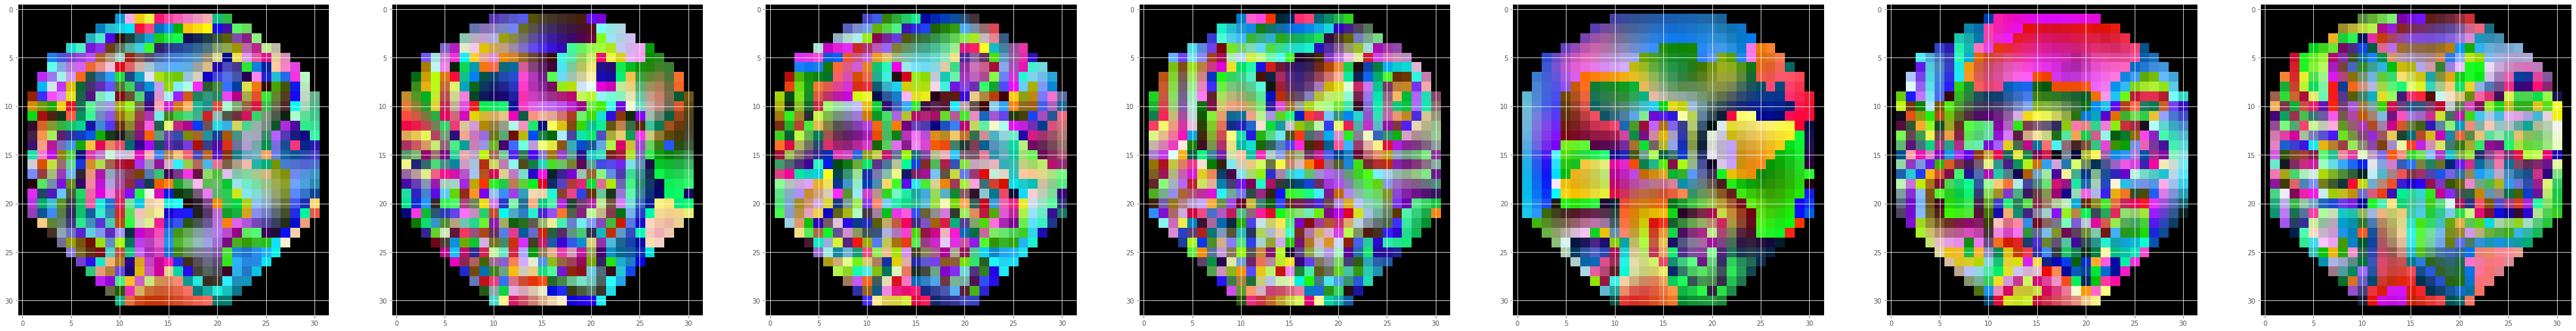

In [17]:
d = [X[i+2] for i in range(8)] # subject 1 ML 0
f, axarr = plt.subplots(1,7, figsize = (70,70))
axarr[0].imshow(im(d[0]))
axarr[1].imshow(im(d[1]))
axarr[2].imshow(im(d[2]))
axarr[3].imshow(im(d[3]))
axarr[4].imshow(im(d[4]))
axarr[5].imshow(im(d[5]))
axarr[6].imshow(im(d[6]))
print('SUBJECT 1 FOR A MENTAL LOAD OF 0')

SUBJECT 2 FOR A MENTAL LOAD OF 0


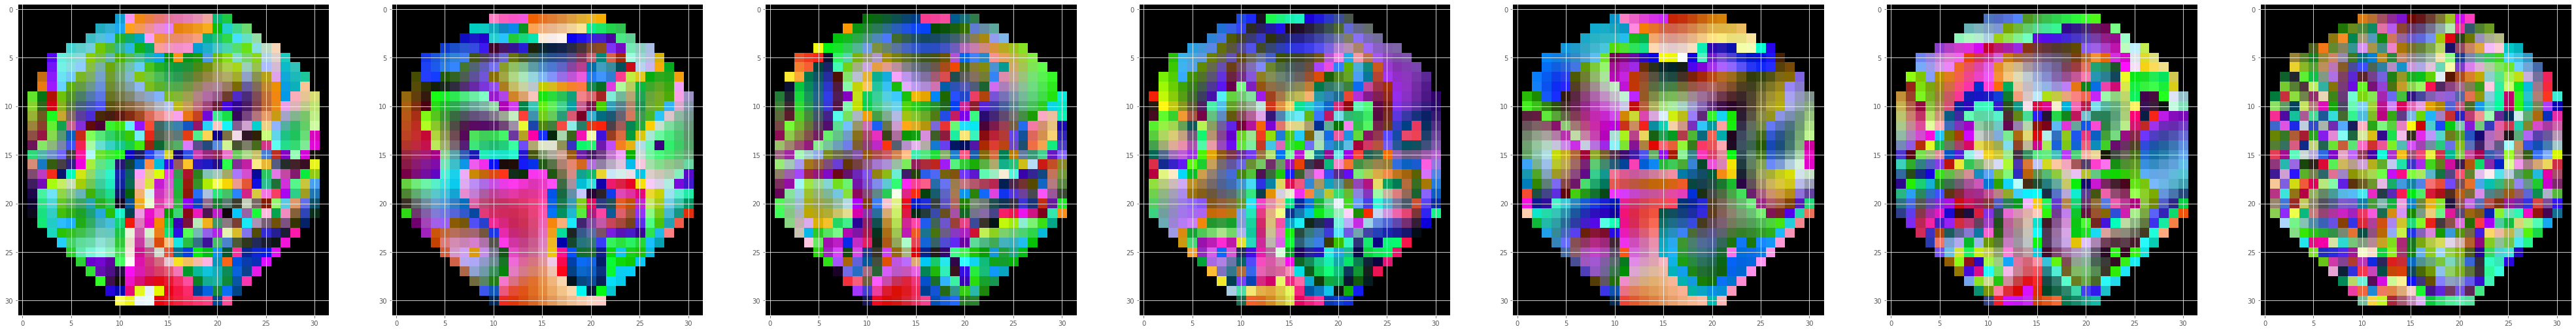

In [18]:
d = [X[57+i] for i in range(10)] # subject 2 ML 0
f, axarr = plt.subplots(1,7, figsize = (70,70))
axarr[0].imshow(im(d[0]))
axarr[1].imshow(im(d[1]))
axarr[2].imshow(im(d[2]))
axarr[3].imshow(im(d[3]))
axarr[4].imshow(im(d[4]))
axarr[5].imshow(im(d[5]))
axarr[6].imshow(im(d[6]))
print('SUBJECT 2 FOR A MENTAL LOAD OF 0')

SUBJECT 1 FOR A MENTAL LOAD OF 1


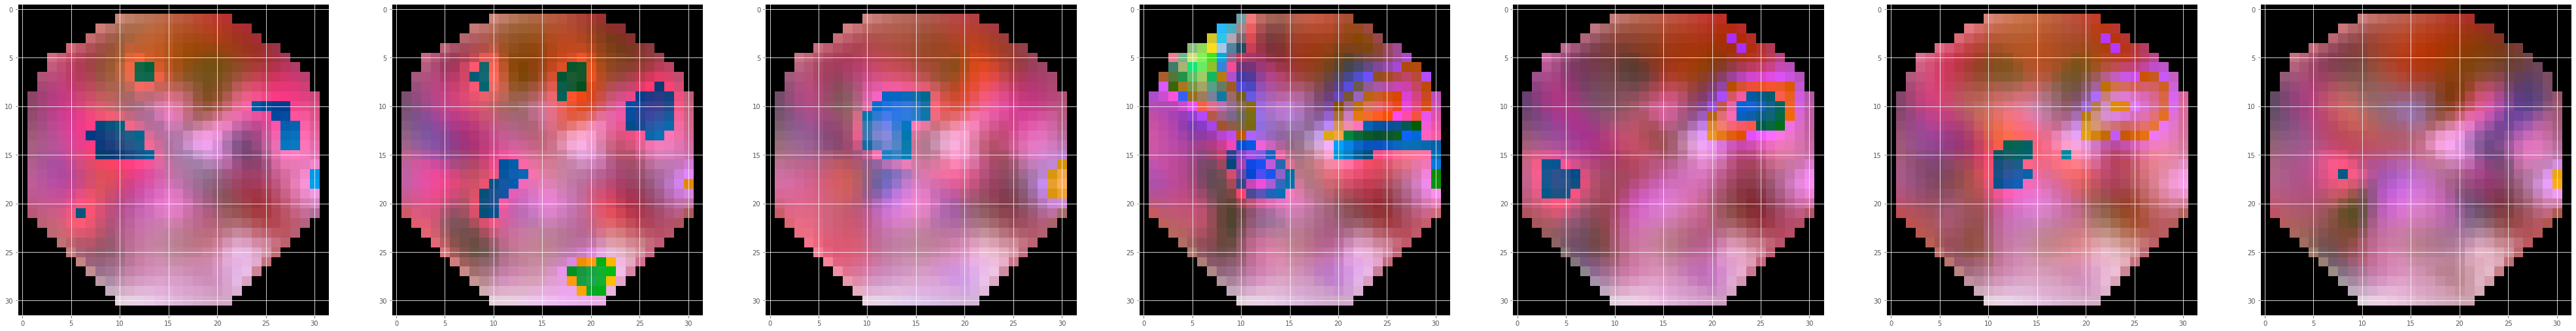

In [19]:
d = [X[757+i] for i in range(10)] # subject 1 ML 1
f, axarr = plt.subplots(1,7, figsize = (70,70))
axarr[0].imshow(im(d[0]))
axarr[1].imshow(im(d[1]))
axarr[2].imshow(im(d[2]))
axarr[3].imshow(im(d[3]))
axarr[4].imshow(im(d[4]))
axarr[5].imshow(im(d[5]))
axarr[6].imshow(im(d[6]))
print('SUBJECT 1 FOR A MENTAL LOAD OF 1')

SUBJECT 2 FOR A MENTAL LOAD OF 1


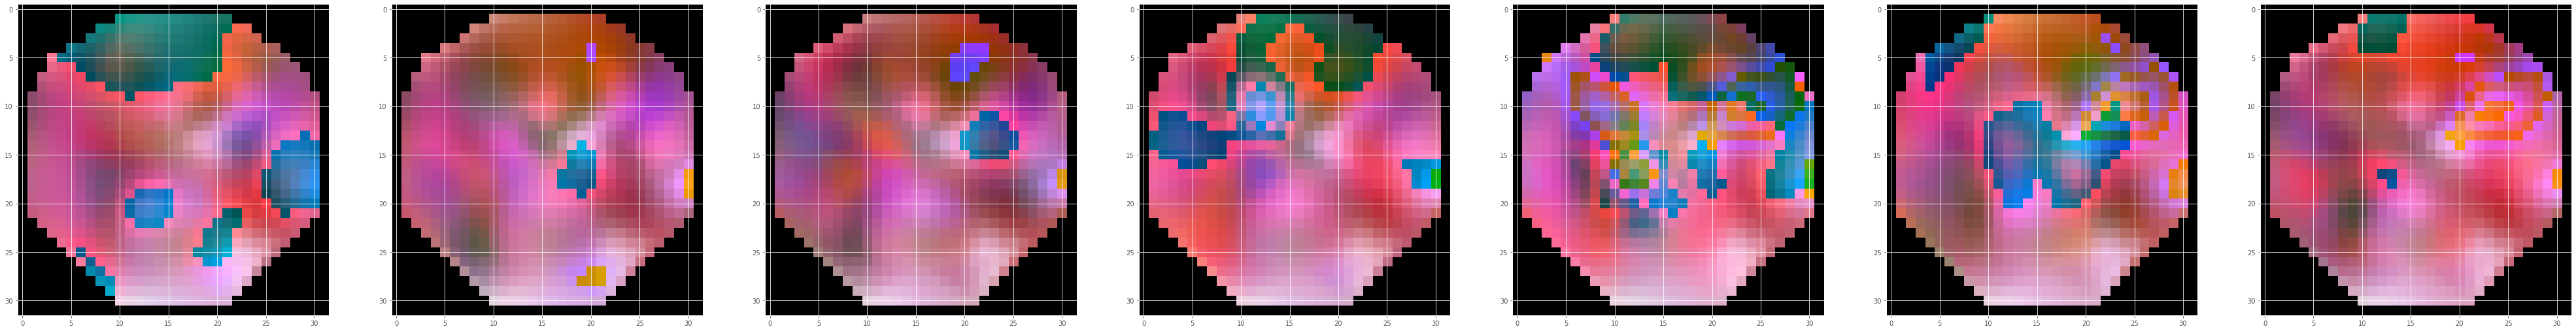

In [20]:
d = [X[805+i] for i in range(10)] # subject 2 ML 1
f, axarr = plt.subplots(1,7, figsize = (70,70))
axarr[0].imshow(im(d[0]))
axarr[1].imshow(im(d[1]))
axarr[2].imshow(im(d[2]))
axarr[3].imshow(im(d[3]))
axarr[4].imshow(im(d[4]))
axarr[5].imshow(im(d[5]))
axarr[6].imshow(im(d[6]))
print('SUBJECT 2 FOR A MENTAL LOAD OF 1')

SUBJECT 1 FOR A MENTAL LOAD OF 2


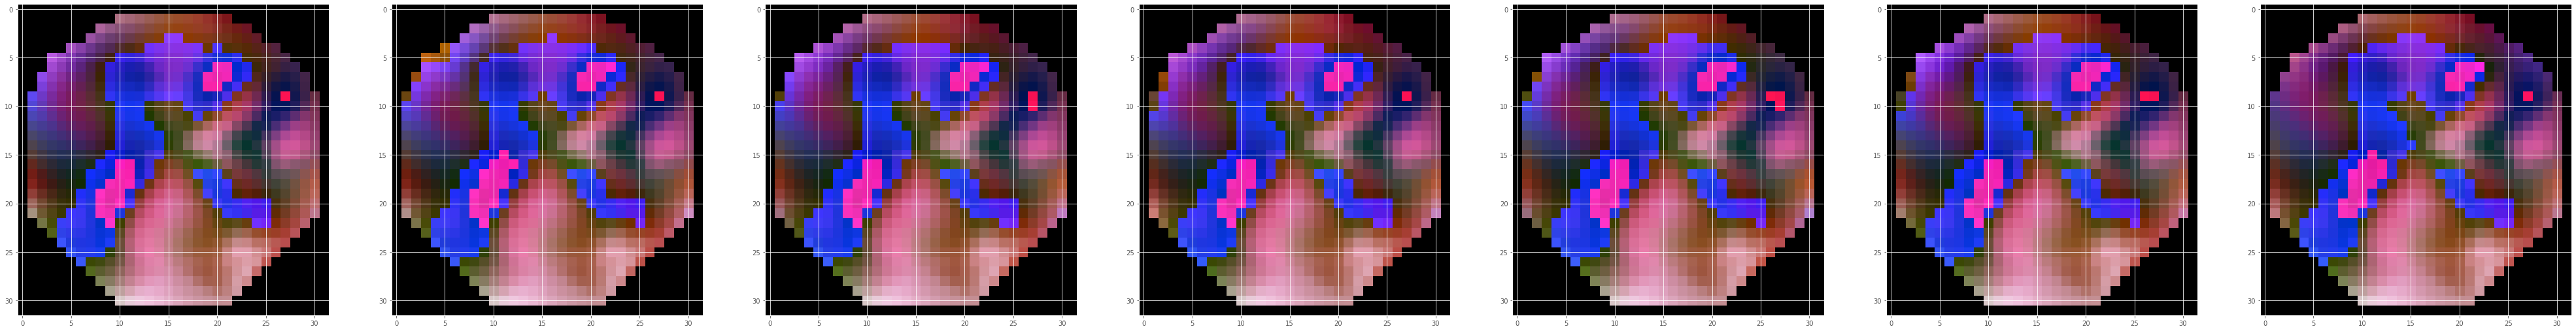

In [21]:
d = [X[1472+i] for i in range(10)] # subject 1 ML 2 
f, axarr = plt.subplots(1,7, figsize = (70,700))
axarr[0].imshow(im(d[0]))
axarr[1].imshow(im(d[1]))
axarr[2].imshow(im(d[2]))
axarr[3].imshow(im(d[3]))
axarr[4].imshow(im(d[4]))
axarr[5].imshow(im(d[5]))
axarr[6].imshow(im(d[6]))
print('SUBJECT 1 FOR A MENTAL LOAD OF 2')

SUBJECT 2 FOR A MENTAL LOAD OF 2


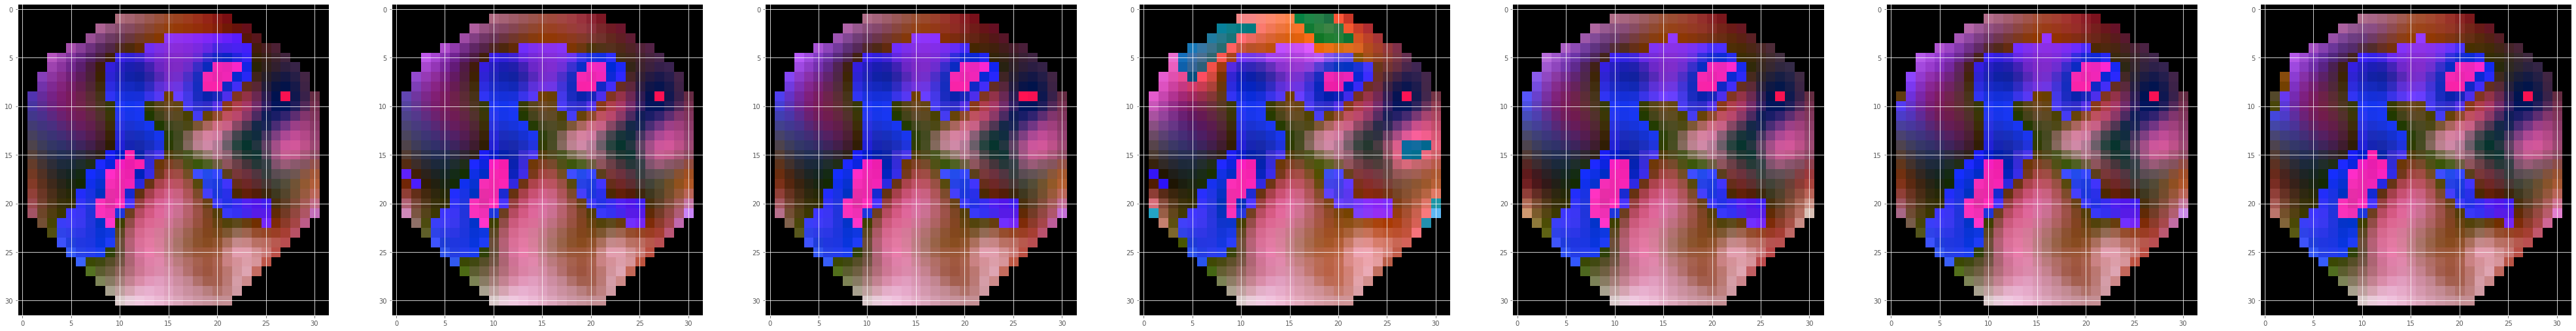

In [22]:
d = [X[1520+i] for i in range(10)] # subject 2 ML 2 
f, axarr = plt.subplots(1,7, figsize = (70,700))
axarr[0].imshow(im(d[0]))
axarr[1].imshow(im(d[1]))
axarr[2].imshow(im(d[2]))
axarr[3].imshow(im(d[3]))
axarr[4].imshow(im(d[4]))
axarr[5].imshow(im(d[5]))
axarr[6].imshow(im(d[6]))
print('SUBJECT 2 FOR A MENTAL LOAD OF 2')

SUBJECT 1 FOR A MENTAL LOAD OF 3


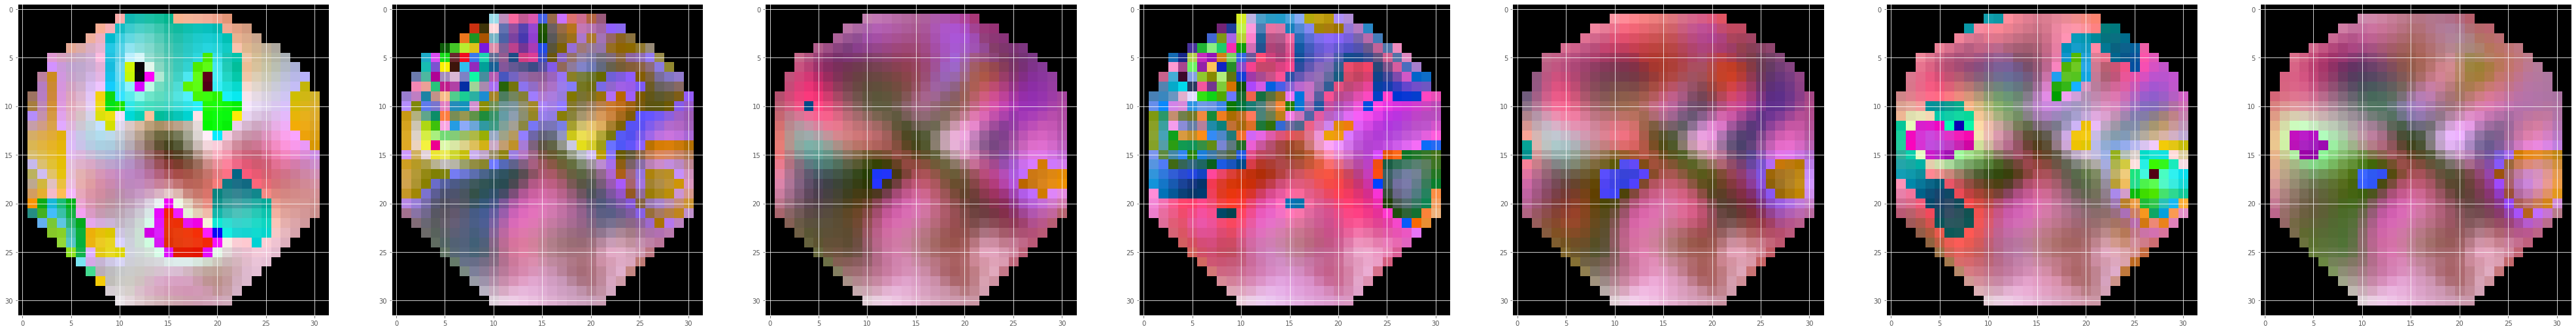

In [23]:
d = [X[2122+i] for i in range(10)] # subject 1 ML 3 
f, axarr = plt.subplots(1,7, figsize = (70,70))
axarr[0].imshow(im(d[0]))
axarr[1].imshow(im(d[1]))
axarr[2].imshow(im(d[2]))
axarr[3].imshow(im(d[3]))
axarr[4].imshow(im(d[4]))
axarr[5].imshow(im(d[5]))
axarr[6].imshow(im(d[6]))
print('SUBJECT 1 FOR A MENTAL LOAD OF 3')

SUBJECT 2 FOR A MENTAL LOAD OF 3


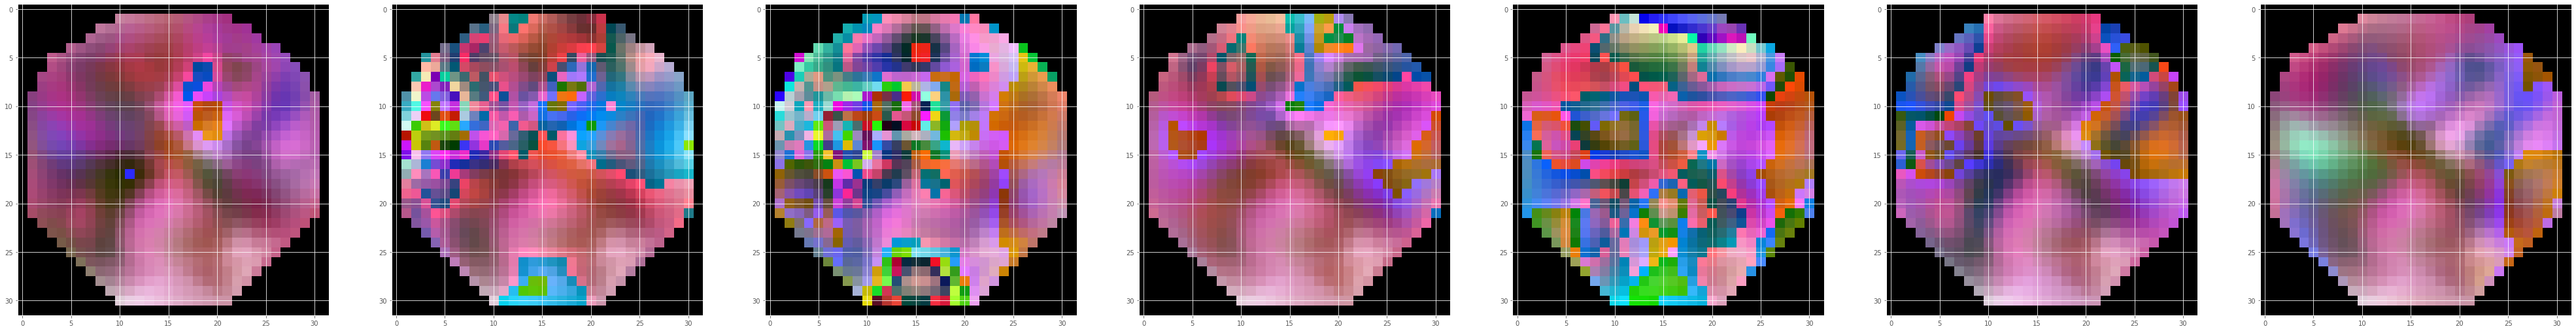

In [24]:
d = [X[2150+i] for i in range(10)] # subject 2 ML 3 
f, axarr = plt.subplots(1,7, figsize = (70,70))
axarr[0].imshow(im(d[0]))
axarr[1].imshow(im(d[1]))
axarr[2].imshow(im(d[2]))
axarr[3].imshow(im(d[3]))
axarr[4].imshow(im(d[4]))
axarr[5].imshow(im(d[5]))
axarr[6].imshow(im(d[6]))
print('SUBJECT 2 FOR A MENTAL LOAD OF 3')

# Two ConvNet configurations tested for mental load-maps classification

## A first Keras ConvNet model 
This model gives an average test accuracy of 94%.

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20,shuffle=True)

In [26]:
# input image dimensions
img_rows, img_cols = X[0].shape[0], X[0].shape[1]
input_shape = (img_rows, img_cols, 3)

In [27]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

batch_size = 128 
num_classes = 4
epochs = 70 

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape)) 
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# using RMSprop optimizer
opt = tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)  


model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_val, x_tes, y_val, y_tes = train_test_split(x_test, y_test, test_size=0.40,shuffle=True)

print(x_train.shape[0], 'train samples')
print(y_train.shape, 'train labels')
print(x_val.shape[0], 'validation samples')
print( y_val.shape, 'validation labels')
print(x_tes.shape[0], 'test samples')
print( y_tes.shape, 'test labels')


model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val),
          shuffle=True) 

2136 train samples
(2136, 4) train labels
320 validation samples
(320, 4) validation labels
214 test samples
(214, 4) test labels
Epoch 1/70
17/17 [==============================] - 8s 37ms/step - loss: 1.3086 - accuracy: 0.3860 - val_loss: 1.1019 - val_accuracy: 0.6156
Epoch 2/70
17/17 [==============================] - 0s 9ms/step - loss: 1.0976 - accuracy: 0.6132 - val_loss: 0.9835 - val_accuracy: 0.5875
Epoch 3/70
17/17 [==============================] - 0s 9ms/step - loss: 0.9734 - accuracy: 0.6725 - val_loss: 0.8516 - val_accuracy: 0.7688
Epoch 4/70
17/17 [==============================] - 0s 8ms/step - loss: 0.8609 - accuracy: 0.7552 - val_loss: 0.7450 - val_accuracy: 0.8156
Epoch 5/70
17/17 [==============================] - 0s 8ms/step - loss: 0.7404 - accuracy: 0.8029 - val_loss: 0.6562 - val_accuracy: 0.8344
Epoch 6/70
17/17 [==============================] - 0s 8ms/step - loss: 0.6566 - accuracy: 0.8306 - val_loss: 0.5822 - val_accuracy: 0.8313
Epoch 7/70
17/17 [===========

In [28]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_tes, y_tes, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
2/2 [==============================] - 0s 21ms/step - loss: 0.1881 - accuracy: 0.9533
test loss, test acc: [0.18807347118854523, 0.9532710313796997]


## A Pytorch ConvNet Model 
This model performs the same classification task as the Keras model but with a slightly inferior accuracy. 

NB : this model needs a GPU for speed. 

In [29]:
import scipy.io as sio 
import seaborn as sn
import pandas as pd

import torch
import os 

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader,random_split

torch.manual_seed(1234)

In [30]:
class EEGImagesDataset(Dataset):
    """EEGLearn Images Dataset from EEG."""
    
    def __init__(self, label, image):
        self.label = Label
        self.Images = image
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.Images[idx]
        label = self.label[idx]
        sample = (image, label)
        
        return sample

In [31]:
Mean_Images = images
print(np.shape(Mean_Images)) 

Label = y.astype(np.int_)
print(np.shape(Label)) 

Patient = sio.loadmat('Sample data/trials_subNums.mat')['subjectNum'][0]
print(np.shape(Patient))

(2670, 3, 32, 32)
(2670,)
(2670,)


In [32]:
device = torch.device("cuda")

In [33]:
def TrainTest_Model(model, trainloader, testloader, n_epoch=30, opti='Adam', learning_rate=0.0001, is_cuda=True, print_epoch =5):
    if is_cuda:
        net = model().cuda()
    else :
        net = model()
        
    criterion = nn.CrossEntropyLoss()
    
    if opti=='SGD':
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    elif opti =='Adam':
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    else: 
        print("Optimizer: "+optim+" not implemented.")
    
    for epoch in range(n_epoch):
        running_loss = 0.0
        evaluation = []
        for i, data in enumerate(Trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.to(torch.float32).cuda())
            _, predicted = torch.max(outputs.cpu().data, 1)
            evaluation.append((predicted==labels).tolist())
            loss = criterion(outputs, labels.cuda())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        running_loss = running_loss/(i+1)
        evaluation = [item for sublist in evaluation for item in sublist]
        running_acc = sum(evaluation)/len(evaluation)
        validation_loss, validation_acc = Test_Model(net, Testloader,optimizer, criterion, True) 
        
        if epoch%print_epoch==(print_epoch-1):
            print('[%d, %3d]\tloss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
             (epoch+1, n_epoch, running_loss, running_acc, validation_loss, validation_acc))
    
    print('Finished Training \n loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
                 (running_loss, running_acc, validation_loss,validation_acc))
    
    return (running_loss, running_acc, validation_loss,validation_acc)

In [34]:
def Test_Model(net, Testloader, optimizer, criterion, is_cuda=True):
    running_loss = 0.0 
    evaluation = []
    for i, data in enumerate(Testloader, 0):
        input_img, labels = data
        optimizer.zero_grad()
        input_img = input_img.to(torch.float32)
        if is_cuda:
            input_img = input_img.cuda()
        outputs = net(input_img)
        _, predicted = torch.max(outputs.cpu().data, 1)
        evaluation.append((predicted==labels).tolist())
        loss = criterion(outputs, labels.cuda())
        running_loss += loss.item()
    running_loss = running_loss/(i+1)
    evaluation = [item for sublist in evaluation for item in sublist]
    running_acc = sum(evaluation)/len(evaluation)
    return running_loss, running_acc

In [35]:
class BasicCNN(nn.Module):
    '''
    Build the  Mean Basic model performing a classification with CNN 

    param input_image: list of EEG image [batch_size, n_window, n_channel, h, w]
    param kernel: kernel size used for the convolutional layers
    param stride: stride apply during the convolutions
    param padding: padding used during the convolutions
    param max_kernel: kernel used for the maxpooling steps
    param n_classes: number of classes
    return x: output of the last layers after the log softmax
    '''
    def __init__(self, input_image=torch.zeros(1, 3, 32, 32), kernel=(3,3), stride=1, padding=1,max_kernel=(2,2), n_classes=4):
        super(BasicCNN, self).__init__()

        n_window = input_image.shape[1]
        n_channel = input_image.shape[2]

        self.conv1 = nn.Conv2d(3,32,kernel,stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(32,32,kernel,stride=stride, padding=padding)
        self.conv3 = nn.Conv2d(32,32,kernel,stride=stride, padding=padding)
        self.conv4 = nn.Conv2d(32,32,kernel,stride=stride, padding=padding)
        self.pool1 = nn.MaxPool2d(max_kernel)
        self.conv5 = nn.Conv2d(32,64,kernel,stride=stride,padding=padding)
        self.conv6 = nn.Conv2d(64,64,kernel,stride=stride,padding=padding)
        self.conv7 = nn.Conv2d(64,128,kernel,stride=stride,padding=padding)

        self.pool = nn.MaxPool2d((1,1))
        self.drop = nn.Dropout(p=0.5)

        self.fc1 = nn.Linear(2048,512)
        self.fc2 = nn.Linear(512,n_classes)
        self.max = nn.LogSoftmax()
    
    def forward(self, x):
        batch_size = x.shape[0]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool1(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool1(x)
        x = F.relu(self.conv7(x))
        x = self.pool1(x)
        x = x.reshape(x.shape[0],x.shape[1], -1)
        x = self.pool(x)
        x = x.reshape(x.shape[0],-1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.max(x)
        return x

In [36]:
EEG = EEGImagesDataset(label=Label, image=Mean_Images)

lengths = [int(2670*0.8), int(2670*0.2)]
Train, Test = random_split(EEG, lengths)

Trainloader = DataLoader(Train,batch_size=32)
Testloader = DataLoader(Test, batch_size=32)

In [37]:
res = TrainTest_Model(BasicCNN, Trainloader, Testloader, n_epoch=10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[5,  10]	loss: 0.400	Accuracy : 0.845		val-loss: 0.314	val-Accuracy : 0.886
[10,  10]	loss: 0.209	Accuracy : 0.912		val-loss: 0.205	val-Accuracy : 0.925
Finished Training 
 loss: 0.209	Accuracy : 0.912		val-loss: 0.205	val-Accuracy : 0.925


In [38]:
def kfold(length, n_fold):
    tot_id = np.arange(length)
    np.random.shuffle(tot_id)
    len_fold = int(length/n_fold)
    train_id = []
    test_id = []
    for i in range(n_fold):
        test_id.append(tot_id[i*len_fold:(i+1)*len_fold])
        train_id.append(np.hstack([tot_id[0:i*len_fold],tot_id[(i+1)*len_fold:-1]]))
    return train_id, test_id

In [39]:
p = 0
n_fold = 5   
n_patient = len(np.unique(Patient))
fold_vloss = np.zeros((n_fold,n_patient))
fold_loss = np.zeros((n_fold,n_patient))
fold_vacc = np.zeros((n_fold,n_patient))
fold_acc = np.zeros((n_fold,n_patient))
for patient in np.unique(Patient):
    id_patient = np.arange(len(Mean_Images))[Patient==patient]
    n_fold = 5
    length = len(id_patient)
    
    n_patient = len(np.unique(Patient))
    
    train_id, test_id = kfold(length,n_fold)
    
    for fold in range(n_fold):
        X_train = Mean_Images[id_patient[train_id[fold]]]
        X_test = Mean_Images[id_patient[test_id[fold]]]
        y_train = Label[id_patient[train_id[fold]]]
        y_test = Label[id_patient[test_id[fold]]] 

        print("Begin Training Fold %d/%d\t of Patient %d" % 
             (fold+1,n_fold, patient))

        CNN = BasicCNN().cuda(0)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(CNN.parameters(), lr=0.001, momentum=0.9)

        n_epochs = 50
        for epoch in range(n_epochs):
            running_loss = 0.0
            batchsize = 5
            for i in range(int(len(y_train)/batchsize)):
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = CNN(torch.from_numpy(X_train[i:i+batchsize]).to(torch.float32).cuda())
                loss = criterion(outputs, torch.from_numpy(y_train[i:i+batchsize]).to(torch.long).cuda())
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            #acc
            _, idx = torch.max(CNN(torch.from_numpy(X_train[:]).to(torch.float32).cuda()).data,1)
            acc = (idx == torch.from_numpy(y_train).cuda()).sum().item()/len(y_train)

            #val Loss
            val_outputs = CNN(torch.from_numpy(X_test[:]).to(torch.float32).cuda())
            val_loss = criterion(val_outputs, torch.from_numpy(y_test[:]).to(torch.long).cuda())
            _, idx = torch.max(val_outputs.data,1)
            val_acc = (idx == torch.from_numpy(y_test).cuda()).sum().item()/len(y_test)

        fold_vloss[fold, p ] = val_loss.item()
        fold_loss[fold, p] = running_loss/i
        fold_vacc[fold, p] = val_acc
        fold_acc[fold, p] = acc
        print('Finish Training Fold %d/%d\t of Patient %d' % 
             (fold+1,n_fold, patient))
    print('loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
                 (np.mean(fold_loss[:,p]), np.mean(fold_acc[:,p]), np.mean(fold_vloss[:,p]),np.mean(fold_vacc[:,p])))
    
    p = p + 1

Begin Training Fold 1/5	 of Patient 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Finish Training Fold 1/5	 of Patient 1
Begin Training Fold 2/5	 of Patient 1
Finish Training Fold 2/5	 of Patient 1
Begin Training Fold 3/5	 of Patient 1
Finish Training Fold 3/5	 of Patient 1
Begin Training Fold 4/5	 of Patient 1
Finish Training Fold 4/5	 of Patient 1
Begin Training Fold 5/5	 of Patient 1
Finish Training Fold 5/5	 of Patient 1
loss: 0.446	Accuracy : 0.757		val-loss: 9.728	val-Accuracy : 0.714
Begin Training Fold 1/5	 of Patient 2
Finish Training Fold 1/5	 of Patient 2
Begin Training Fold 2/5	 of Patient 2
Finish Training Fold 2/5	 of Patient 2
Begin Training Fold 3/5	 of Patient 2
Finish Training Fold 3/5	 of Patient 2
Begin Training Fold 4/5	 of Patient 2
Finish Training Fold 4/5	 of Patient 2
Begin Training Fold 5/5	 of Patient 2
Finish Training Fold 5/5	 of Patient 2
loss: 0.072	Accuracy : 0.871		val-loss: 1.987	val-Accuracy : 0.862
Begin Training Fold 1/5	 of Patient 3
Finish Training Fold 1/5	 of Patient 3
Begin Training Fold 2/5	 of Patient 3
Finish Training Fol

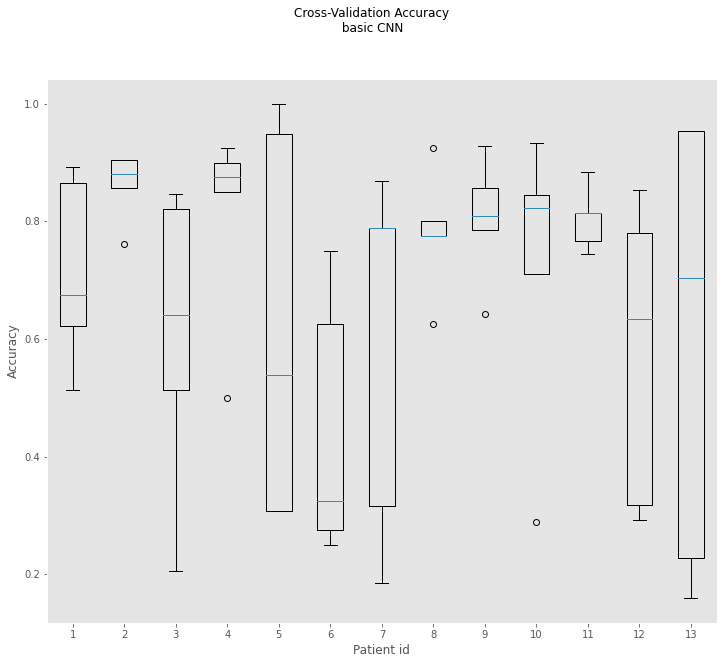

In [53]:
fig = plt.figure(figsize=(12,10))
plt.grid()
plt.boxplot(fold_vacc)
plt.suptitle('Cross-Validation Accuracy\n basic CNN')
ax = plt.gca()
plt.xlabel('Patient id')
plt.ylabel('Accuracy')
plt.savefig('fig.png')
plt.show()

# LIME analysis
Lime allows to explain how the classification is done, by highlighting the elements on which the model focuses to decide of the predicted label.

In [41]:
! pip install lime

     |████████████████████████████████| 276kB 15.2MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283846 sha256=a7c6f4fe85d413c2ccb677b9e51f23583ddf565eabbc3016afc8531d583a6aec
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [42]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) 
    import lime
from lime import lime_image

In [43]:
explainer = lime_image.LimeImageExplainer()

In [44]:
from skimage.segmentation import mark_boundaries

In [45]:
%%time
explanation = explainer.explain_instance(X[2].astype('double'), model.predict, top_labels=4, hide_color=0, num_samples=1000)



CPU times: user 3.21 s, sys: 143 ms, total: 3.36 s
Wall time: 3.33 s


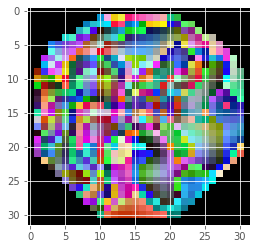

In [46]:
imashow(X[2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


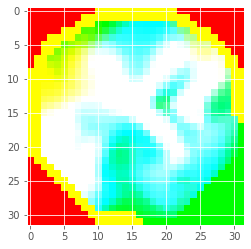

In [47]:
# We can see the 'pros and cons' (pros in green, cons in red)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.figure(figsize = (4,4))
plt.imshow(mark_boundaries(temp, mask))

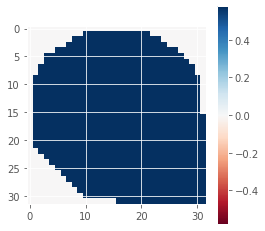

In [48]:
# Alternatively, we can plot explanation weights onto a heatmap visualization. The colorbar shows the values of the weights.
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot.
plt.figure(figsize = (4,4))
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [49]:
%%time
explanation = explainer.explain_instance(X[528].astype('double'), model.predict, top_labels=4, hide_color=0, num_samples=1000)


CPU times: user 3.33 s, sys: 130 ms, total: 3.46 s
Wall time: 3.44 s


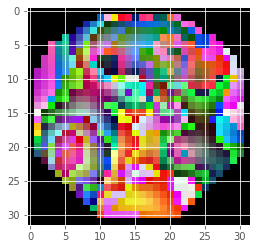

In [50]:
imashow(X[528])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


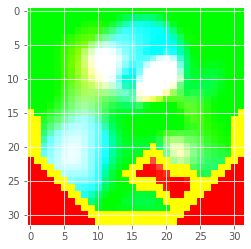

In [51]:
# We can see the 'pros and cons' (pros in green, cons in red)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.figure(figsize = (4,4))
plt.imshow(mark_boundaries(temp, mask))

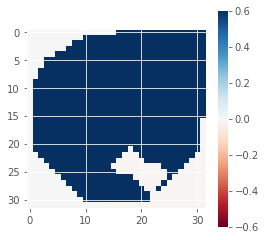

In [52]:
# Alternatively, we can plot explanation weights onto a heatmap visualization. The colorbar shows the values of the weights.
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. 
plt.figure(figsize = (4,4))
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()